In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, log_loss
)
from sklearn.inspection import permutation_importance

import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Load data ---
df = pd.read_csv("../data/Landslide_dataSet1.csv")

In [3]:
# --- Ensure expected columns exist (safe defaults) ---
expected_cols = ['timestamp', 'devID', 'soil', 'rain', 'temp', 'humi', 'geo']
for c in expected_cols:
    if c not in df.columns:
        df[c] = np.nan  # create if missing to avoid crash (but user should check source)

In [4]:
# --- Create rain_3h_sum robustly ---
def compute_rain_3h_sum(df, time_col='timestamp', device_col='devID', rain_col='rain'):
    df = df.copy()
    # Try parse timestamps
    try:
        df[time_col] = pd.to_datetime(df[time_col])
        # Apply per-device time-based rolling window (3 hours)
        out = []
        for dev, g in df.groupby(device_col):
            g = g.sort_values(time_col).set_index(time_col)
            # rolling with time window (3H)
            rain_3h = g[rain_col].rolling('3H').sum()
            g = g.assign(rain_3h_sum = rain_3h.values)
            out.append(g.reset_index())
        return pd.concat(out, ignore_index=True)
    except Exception:
        # Fallback: use rolling window of last 3 records per device
        out = []
        for dev, g in df.groupby(device_col):
            g = g.sort_values(time_col).reset_index(drop=True)
            g['rain_3h_sum'] = g[rain_col].rolling(window=3, min_periods=1).sum()
            out.append(g)
        return pd.concat(out, ignore_index=True)

df = compute_rain_3h_sum(df, time_col='timestamp', device_col='devID', rain_col='rain')

In [5]:
# --- Labeling function (parameterized) ---
def risk_score(row, soil_weights=(20,30,40), rain_weights=(5,10,20), geo_weights=(2,4,6)):
    score = 0
    # soil moisture score
    if row['soil'] > soil_weights[2]:
        score += 3
    elif row['soil'] > soil_weights[1]:
        score += 2
    elif row['soil'] > soil_weights[0]:
        score += 1
    # rain in last 3 hours
    if row.get('rain_3h_sum', np.nan) > rain_weights[2]:
        score += 3
    elif row.get('rain_3h_sum', np.nan) > rain_weights[1]:
        score += 2
    elif row.get('rain_3h_sum', np.nan) > rain_weights[0]:
        score += 1
    # geo movement score
    if row['geo'] > geo_weights[2]:
        score += 3
    elif row['geo'] > geo_weights[1]:
        score += 2
    elif row['geo'] > geo_weights[0]:
        score += 1
    return score

def classify_risk_from_score(score, thresholds=(5,8)):
    # thresholds: [>=thresholds[1] -> Critical(2), >=thresholds[0] -> Warning(1), else Normal(0)]
    if score >= thresholds[1]:
        return 2
    elif score >= thresholds[0]:
        return 1
    else:
        return 0

# Apply labeling
df['risk_score_calc'] = df.apply(risk_score, axis=1)
df['risk_level'] = df['risk_score_calc'].apply(lambda s: classify_risk_from_score(s, thresholds=(5,8)))


In [6]:
# --- Features and target ---
features = ['soil', 'rain', 'temp', 'humi', 'geo']
X = df[features].copy()
y = df['risk_level'].copy()

In [7]:
# --- Handle missing values: fill with median (per feature) ---
X = X.fillna(X.median())

In [8]:
# --- Train / Test split (stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)


In [9]:
# --- Optionally use SMOTE if installed (helps class imbalance) ---
use_smote = False
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    use_smote = True
except Exception:
    use_smote = False

In [10]:
# --- Build pipeline ---
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

if use_smote:
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('clf', rf)
    ])
else:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', rf)
    ])

In [11]:
# --- Hyperparameter tuning: Randomized Search (faster than grid) ---
param_dist = {
    'clf__n_estimators': [100, 200, 400, 800],
    'clf__max_depth': [None, 6, 10, 20, 40],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__class_weight': [None, 'balanced', 'balanced_subsample']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=cv,
    random_state=RANDOM_STATE,
    verbose=1
)

rs.fit(X_train, y_train)

best_model = rs.best_estimator_
print("Best params:", rs.best_params_)
print("Best CV balanced_accuracy:", rs.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_depth': None, 'clf__class_weight': None}
Best CV balanced_accuracy: 0.9977658932397867


In [12]:

# --- Evaluate on test set ---
y_pred = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)
else:
    # fallback: one-hot encode predictions as degenerate probabilities
    y_proba = np.eye(len(np.unique(y)))[y_pred]

loss = log_loss(y_test, y_proba, labels=[0,1,2])
accuracy = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.3f}  Balanced Accuracy: {balanced_acc:.3f}")
print(f"Precision: {precision:.3f}  Recall: {recall:.3f}  F1: {f1:.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Log Loss: 0.0048
Accuracy: 1.000  Balanced Accuracy: 0.994
Precision: 1.000  Recall: 1.000  F1: 1.000
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     46465
           1       1.00      1.00      1.00     29416
           2       0.99      0.98      0.99       642

    accuracy                           1.00     76523
   macro avg       1.00      0.99      1.00     76523
weighted avg       1.00      1.00      1.00     76523



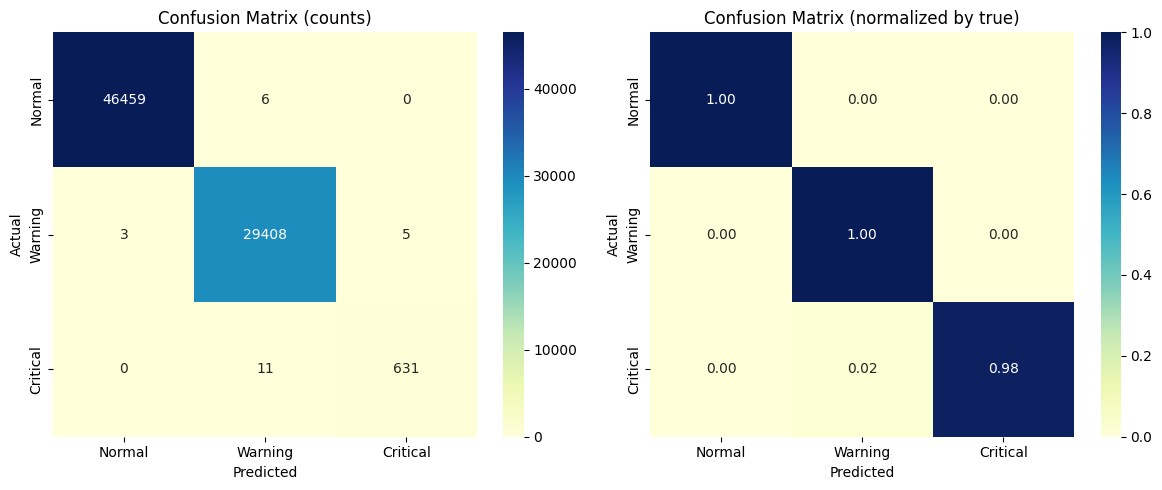

In [13]:
# --- Confusion matrix (counts + normalized) ---
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=["Normal","Warning","Critical"], yticklabels=["Normal","Warning","Critical"])
plt.title("Confusion Matrix (counts)")
plt.xlabel("Predicted"); plt.ylabel("Actual")

plt.subplot(1,2,2)
sns.heatmap(np.round(cm_norm,2), annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=["Normal","Warning","Critical"], yticklabels=["Normal","Warning","Critical"])
plt.title("Confusion Matrix (normalized by true)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [14]:
# --- Cross-validated accuracy on full dataset for reference ---
cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("Cross-val accuracies (accuracy):", np.round(cv_scores,3))
print("Mean accuracy from CV:", np.round(cv_scores.mean(),3))


Cross-val accuracies (accuracy): [1. 1. 1. 1. 1.]
Mean accuracy from CV: 1.0


In [15]:
# --- Feature importances (from RF) ---
# If pipeline, classifier is at step 'clf'
clf_step = best_model.named_steps['clf'] if hasattr(best_model, 'named_steps') else best_model
feat_importances = clf_step.feature_importances_
feat_df = pd.DataFrame({'feature': features, 'importance': feat_importances}).sort_values('importance', ascending=False)
print("Feature importances:\n", feat_df)

Feature importances:
   feature  importance
4     geo    0.614269
0    soil    0.330605
1    rain    0.041274
3    humi    0.006994
2    temp    0.006858


In [16]:
# Permutation importance (robust)
perm = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
perm_df = pd.DataFrame({'feature': features, 'perm_importance_mean': perm.importances_mean, 'perm_importance_std': perm.importances_std})
perm_df = perm_df.sort_values('perm_importance_mean', ascending=False)
print("Permutation importances:\n", perm_df)

Permutation importances:
   feature  perm_importance_mean  perm_importance_std
4     geo              0.368895             0.001335
0    soil              0.205672             0.000783
1    rain              0.024540             0.000161
3    humi              0.000157             0.000027
2    temp              0.000118             0.000030


In [17]:
# --- Save model ---
os.makedirs("model", exist_ok=True)
joblib.dump(best_model, "model/landsilde_rf_pipeline_best.joblib")
print("Saved best model to model/landsilde_rf_pipeline_best.joblib")

Saved best model to model/landsilde_rf_pipeline_best.joblib
